In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "MYB_related"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = False

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
22773,678442875,MSCDLTDHSFDWLLEKGEVCVGVKGRRAAAALNKRSSLQRRLPLIP...,346,0
29306,Pp3c18_6880V3.11.p,MRSYSSEIGPISGMGSLDEEISAMLQSSHASFSDASLAGVMATETS...,475,0
15295,Zpz_sc00816.1.g00080.1.sm.mkhc,MPNAKSAPGTRQWAAWTRQEEENFFNALRQVGKNFEKITHRVQSKN...,322,1
2779,CA00g25300,MSGICLKDSFYEQDNLSFPLICADWNADEEMLLLEGLEMYGLANWA...,195,1
20174,Dca36594.1,MSFTGDDDYNDGDYEVDDGDYEVDDQSALGDDNISVDALLGDGIDY...,542,0


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 22773 to 3944
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5000 non-null   object
 1   sequence  5000 non-null   object
 2   length    5000 non-null   int64 
 3   class     5000 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 195.3+ KB


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
2501,0.000000,0.000000,0.011765,0.000000,0.000000,0.000000,0.000000,0.011765,0.011765,0.011765,...,0.011765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2343,0.014545,0.001818,0.001818,0.005455,0.001818,0.007273,0.000000,0.000000,0.001818,0.000000,...,0.001818,0.001818,0.000000,0.001818,0.001818,0.000000,0.000000,0.000000,0.0,0.003636
4473,0.004552,0.000000,0.003035,0.001517,0.001517,0.003035,0.000000,0.001517,0.003035,0.004552,...,0.006070,0.000000,0.000000,0.006070,0.001517,0.001517,0.001517,0.000000,0.0,0.000000
1351,0.000000,0.000000,0.005976,0.009960,0.000000,0.003984,0.003984,0.003984,0.001992,0.001992,...,0.000000,0.001992,0.003984,0.003984,0.001992,0.000000,0.001992,0.000000,0.0,0.000000
2124,0.000000,0.000000,0.000000,0.000000,0.000000,0.005848,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.011696,0.000000,0.005848,0.000000,0.000000,0.000000,0.005848,0.0,0.000000


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 441)
X_test: (1000, 441)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 22s 465ms/step - accuracy: 0.6562 - loss: 0.6926

39/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5402 - loss: 0.6901   

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5531 - loss: 0.6869 - val_accuracy: 0.7763 - val_loss: 0.5717


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7656 - loss: 0.6207

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8060 - loss: 0.5243

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8082 - loss: 0.5106 - val_accuracy: 0.8625 - val_loss: 0.3332


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8750 - loss: 0.3187

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8634 - loss: 0.3215

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8635 - loss: 0.3235 - val_accuracy: 0.8662 - val_loss: 0.3206


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8438 - loss: 0.3432

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8661 - loss: 0.3190

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8681 - loss: 0.3168 - val_accuracy: 0.8950 - val_loss: 0.2800


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8906 - loss: 0.2181

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8885 - loss: 0.2616

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8865 - loss: 0.2693 - val_accuracy: 0.8988 - val_loss: 0.2711


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8750 - loss: 0.2750

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9030 - loss: 0.2596

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9041 - loss: 0.2562 - val_accuracy: 0.8888 - val_loss: 0.2682


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9062 - loss: 0.2479

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9041 - loss: 0.2496

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9042 - loss: 0.2464 - val_accuracy: 0.9013 - val_loss: 0.2602


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9062 - loss: 0.2994

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9163 - loss: 0.2375

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9159 - loss: 0.2349 - val_accuracy: 0.8950 - val_loss: 0.2686


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9219 - loss: 0.3100

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9238 - loss: 0.2249

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9232 - loss: 0.2222 - val_accuracy: 0.8637 - val_loss: 0.3244


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8906 - loss: 0.2861

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9229 - loss: 0.2009

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9256 - loss: 0.1976 - val_accuracy: 0.8913 - val_loss: 0.2706


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9219 - loss: 0.1687

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9293 - loss: 0.1803

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9313 - loss: 0.1783 - val_accuracy: 0.9050 - val_loss: 0.2539


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8906 - loss: 0.3055

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9125 - loss: 0.2105

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9171 - loss: 0.2015 - val_accuracy: 0.9075 - val_loss: 0.2474


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9531 - loss: 0.1281

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9548 - loss: 0.1236

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9543 - loss: 0.1264 - val_accuracy: 0.8988 - val_loss: 0.2610


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9375 - loss: 0.1746

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9596 - loss: 0.1178

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9586 - loss: 0.1186 - val_accuracy: 0.8938 - val_loss: 0.2816


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0582

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9672 - loss: 0.0991

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9668 - loss: 0.0995 - val_accuracy: 0.8938 - val_loss: 0.2860


Epoch 16/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9531 - loss: 0.0906

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9724 - loss: 0.0787

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9733 - loss: 0.0781 - val_accuracy: 0.9038 - val_loss: 0.2927


Epoch 17/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.1302

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9744 - loss: 0.0881

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9751 - loss: 0.0841 - val_accuracy: 0.8988 - val_loss: 0.3415


Epoch 18/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0813

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9871 - loss: 0.0547

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9868 - loss: 0.0546 - val_accuracy: 0.9013 - val_loss: 0.3044


Epoch 19/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0160

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9927 - loss: 0.0343

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9917 - loss: 0.0371 - val_accuracy: 0.9087 - val_loss: 0.3335


Epoch 20/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.0429

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9893 - loss: 0.0321

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9885 - loss: 0.0347 - val_accuracy: 0.9025 - val_loss: 0.3554


Epoch 21/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0211

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9861 - loss: 0.0437

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9870 - loss: 0.0421 - val_accuracy: 0.8950 - val_loss: 0.4082


Epoch 22/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9531 - loss: 0.1055

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9740 - loss: 0.0618

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9749 - loss: 0.0611 - val_accuracy: 0.9025 - val_loss: 0.3403


Epoch 23/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0134

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9916 - loss: 0.0321

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9909 - loss: 0.0339 - val_accuracy: 0.8988 - val_loss: 0.3864


Epoch 24/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.0389

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9808 - loss: 0.0541

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9820 - loss: 0.0503 - val_accuracy: 0.9025 - val_loss: 0.3611


Epoch 25/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.0406

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9873 - loss: 0.0379

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9880 - loss: 0.0362 - val_accuracy: 0.8875 - val_loss: 0.4516


Epoch 26/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0143

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9844 - loss: 0.0451

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9855 - loss: 0.0425 - val_accuracy: 0.9062 - val_loss: 0.3789


Epoch 27/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0023

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9968 - loss: 0.0155

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0165 - val_accuracy: 0.9112 - val_loss: 0.3847


Epoch 28/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0049

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9987 - loss: 0.0102

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0110 - val_accuracy: 0.9000 - val_loss: 0.4260


Epoch 29/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0147

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9963 - loss: 0.0077

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0083 - val_accuracy: 0.9062 - val_loss: 0.4286


Epoch 30/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0018

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9953 - loss: 0.0172

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0165 - val_accuracy: 0.9038 - val_loss: 0.4225


Epoch 31/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0021

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9976 - loss: 0.0082

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0091 - val_accuracy: 0.9112 - val_loss: 0.4333


Epoch 32/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0051

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9907 - loss: 0.0259

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0240 - val_accuracy: 0.9075 - val_loss: 0.4185


Epoch 33/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.0125

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9961 - loss: 0.0093

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0101 - val_accuracy: 0.8925 - val_loss: 0.5038


Epoch 34/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0128

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9946 - loss: 0.0210

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0186 - val_accuracy: 0.9013 - val_loss: 0.4429


Epoch 35/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0478

38/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9929 - loss: 0.0235

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9915 - loss: 0.0276 - val_accuracy: 0.8963 - val_loss: 0.4579


Epoch 36/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0058

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9926 - loss: 0.0201

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0189 - val_accuracy: 0.8950 - val_loss: 0.5393


Epoch 37/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0109

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9929 - loss: 0.0205

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0214 - val_accuracy: 0.9075 - val_loss: 0.4033



[Train Accuracy: 99.22% - Test Accuracy: 89.90%]


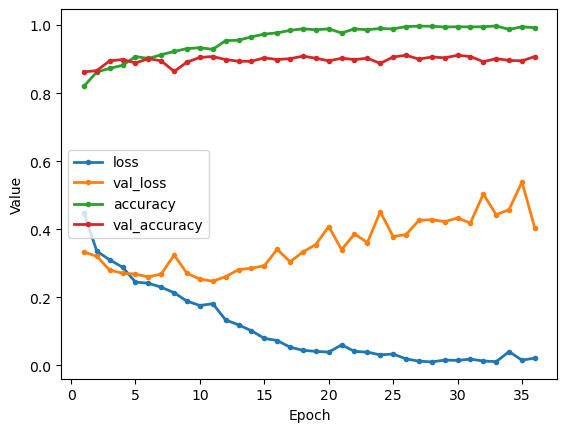

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
1639,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4380,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2906,0.015075,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.005025,0.005025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4580,0.000000,0.0,0.0,0.0,0.0,0.011765,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2944,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 8763)
X_test: (1000, 8763)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,243,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,286,849 (8.72 MB)

 Trainable params: 2,286,849 (8.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 22s 465ms/step - accuracy: 0.5156 - loss: 0.6931

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5043 - loss: 0.6932   

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5089 - loss: 0.6931

26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5102 - loss: 0.6927

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5133 - loss: 0.6920

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5201 - loss: 0.6906

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5301 - loss: 0.6879

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5313 - loss: 0.6875 - val_accuracy: 0.9275 - val_loss: 0.5661


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9375 - loss: 0.5401

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8948 - loss: 0.5215 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8774 - loss: 0.4950

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8772 - loss: 0.4696

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8798 - loss: 0.4493

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8835 - loss: 0.4273

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8863 - loss: 0.4119 - val_accuracy: 0.9275 - val_loss: 0.1977


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9375 - loss: 0.1983

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9508 - loss: 0.1537 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9607 - loss: 0.1300

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9638 - loss: 0.1230

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9645 - loss: 0.1213

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9650 - loss: 0.1197

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9652 - loss: 0.1192 - val_accuracy: 0.9375 - val_loss: 0.1946


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9531 - loss: 0.1074

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9761 - loss: 0.0707 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9797 - loss: 0.0688

26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9808 - loss: 0.0698

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9807 - loss: 0.0717

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9805 - loss: 0.0731

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9804 - loss: 0.0741

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9804 - loss: 0.0741 - val_accuracy: 0.9287 - val_loss: 0.2291


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0262

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9950 - loss: 0.0381 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9945 - loss: 0.0375

26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9938 - loss: 0.0381

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9933 - loss: 0.0387

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9930 - loss: 0.0391

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9927 - loss: 0.0400

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9926 - loss: 0.0401 - val_accuracy: 0.9262 - val_loss: 0.2653


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0101

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9963 - loss: 0.0267 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9949 - loss: 0.0287

26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9943 - loss: 0.0289

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9940 - loss: 0.0293

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9938 - loss: 0.0296

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9937 - loss: 0.0297 - val_accuracy: 0.9262 - val_loss: 0.3154


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9844 - loss: 0.0257

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9907 - loss: 0.0277 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9917 - loss: 0.0257

26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9922 - loss: 0.0256

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9929 - loss: 0.0244

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9933 - loss: 0.0233

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9937 - loss: 0.0225 - val_accuracy: 0.9262 - val_loss: 0.3082


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0021

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9977 - loss: 0.0099 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9979 - loss: 0.0099

26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9981 - loss: 0.0093

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9984 - loss: 0.0087

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9984 - loss: 0.0085

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9984 - loss: 0.0085 - val_accuracy: 0.9038 - val_loss: 0.3405


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0039

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0045 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0038

26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0035

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0034

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0034

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0034 - val_accuracy: 0.9237 - val_loss: 0.3469


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0024

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9275 - val_loss: 0.3926


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 3.1074e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.0235e-04 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2147e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.4994e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6110e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6509e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6978e-04 - val_accuracy: 0.9275 - val_loss: 0.4152


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.9252e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9028e-04 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2148e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.4646e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6442e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7193e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7357e-04 - val_accuracy: 0.9300 - val_loss: 0.4107


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.0388e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.5231e-04 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0658e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8527e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7578e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6859e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6547e-04 - val_accuracy: 0.9312 - val_loss: 0.4197



[Train Accuracy: 100.00% - Test Accuracy: 91.20%]

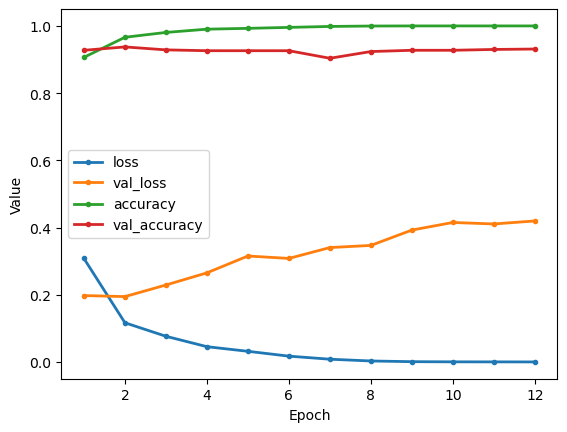

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYK,YYYL,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYV,YYYY
1639,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4380,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2906,0.005051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005051,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4580,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2944,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      37,133,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,174,273 (141.81 MB)

 Trainable params: 37,174,273 (141.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 31s 643ms/step - accuracy: 0.5781 - loss: 0.6931

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.5898 - loss: 0.6927 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.5738 - loss: 0.6929

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.5612 - loss: 0.6931

 5/50 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.5527 - loss: 0.6931

 6/50 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.5474 - loss: 0.6931

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.5435 - loss: 0.6931

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.5405 - loss: 0.6931

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.5391 - loss: 0.6930

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.5375 - loss: 0.6930

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.5362 - loss: 0.6929

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.5344 - loss: 0.6929

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.5330 - loss: 0.6928

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.5318 - loss: 0.6928

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.5306 - loss: 0.6927

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.5291 - loss: 0.6927

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.5277 - loss: 0.6927

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.5262 - loss: 0.6926

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.5248 - loss: 0.6926

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.5234 - loss: 0.6926

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.5219 - loss: 0.6925

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.5206 - loss: 0.6925

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.5194 - loss: 0.6925

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.5186 - loss: 0.6924

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.5178 - loss: 0.6923

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.5170 - loss: 0.6923

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5163 - loss: 0.6922

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5157 - loss: 0.6921

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5153 - loss: 0.6920

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5150 - loss: 0.6918

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5148 - loss: 0.6917

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.5145 - loss: 0.6915

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.5143 - loss: 0.6914

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5141 - loss: 0.6912

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5139 - loss: 0.6911

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5139 - loss: 0.6909

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5140 - loss: 0.6907

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5142 - loss: 0.6905

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5146 - loss: 0.6902

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5150 - loss: 0.6900

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5155 - loss: 0.6897

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5161 - loss: 0.6895

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5167 - loss: 0.6892

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5174 - loss: 0.6888

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5180 - loss: 0.6885

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5187 - loss: 0.6882

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5193 - loss: 0.6878

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5200 - loss: 0.6875

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5207 - loss: 0.6871

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5216 - loss: 0.6868

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.5224 - loss: 0.6864 - val_accuracy: 0.8363 - val_loss: 0.5826


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 12s 261ms/step - accuracy: 0.9531 - loss: 0.5235

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9336 - loss: 0.5296 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9193 - loss: 0.5322

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9102 - loss: 0.5325

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9038 - loss: 0.5317

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.8968 - loss: 0.5302

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.8924 - loss: 0.5281

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.8883 - loss: 0.5260

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.8856 - loss: 0.5238

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.8836 - loss: 0.5218

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.8821 - loss: 0.5194

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.8807 - loss: 0.5171

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.8799 - loss: 0.5147

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.8794 - loss: 0.5123

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.8795 - loss: 0.5096

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.8800 - loss: 0.5069

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.8807 - loss: 0.5040

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.8812 - loss: 0.5013

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.8818 - loss: 0.4984

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.8824 - loss: 0.4955

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.8830 - loss: 0.4927

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.8834 - loss: 0.4901

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.8838 - loss: 0.4874

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.8843 - loss: 0.4848

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.8848 - loss: 0.4822

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.8854 - loss: 0.4796

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.8861 - loss: 0.4770

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.8868 - loss: 0.4743

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.8875 - loss: 0.4716

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.8882 - loss: 0.4689

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.8889 - loss: 0.4662

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.8896 - loss: 0.4635

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.8903 - loss: 0.4608

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.8909 - loss: 0.4582

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.8915 - loss: 0.4557

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.8921 - loss: 0.4532

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.8927 - loss: 0.4506

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.8933 - loss: 0.4481

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.8939 - loss: 0.4455

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.8946 - loss: 0.4430

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.8952 - loss: 0.4404

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8958 - loss: 0.4379

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8964 - loss: 0.4354

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8971 - loss: 0.4329

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8977 - loss: 0.4304

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8983 - loss: 0.4280

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8989 - loss: 0.4256

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8994 - loss: 0.4232

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9000 - loss: 0.4208

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9006 - loss: 0.4185

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 0.9011 - loss: 0.4162 - val_accuracy: 0.9287 - val_loss: 0.1869


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 1.0000 - loss: 0.0284

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 0.0299

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 0.0306

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9990 - loss: 0.0339

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9980 - loss: 0.0372

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9974 - loss: 0.0388

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9972 - loss: 0.0395

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9968 - loss: 0.0399

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9966 - loss: 0.0400

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9963 - loss: 0.0401

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9960 - loss: 0.0402

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9957 - loss: 0.0403

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9954 - loss: 0.0402

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9952 - loss: 0.0403

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9950 - loss: 0.0403

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.9949 - loss: 0.0402

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9948 - loss: 0.0403

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9946 - loss: 0.0405

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9944 - loss: 0.0406

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9943 - loss: 0.0407

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9942 - loss: 0.0407

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9941 - loss: 0.0407

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9940 - loss: 0.0407

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9939 - loss: 0.0407

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9938 - loss: 0.0407

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9937 - loss: 0.0407

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9936 - loss: 0.0406

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.9936 - loss: 0.0405

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9935 - loss: 0.0404

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9935 - loss: 0.0403

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.9934 - loss: 0.0402

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9934 - loss: 0.0401

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9933 - loss: 0.0401

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9932 - loss: 0.0401

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9932 - loss: 0.0400

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9931 - loss: 0.0400

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9930 - loss: 0.0400

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9930 - loss: 0.0399

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9929 - loss: 0.0399

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9929 - loss: 0.0399

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9928 - loss: 0.0399

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.9927 - loss: 0.0399

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9927 - loss: 0.0400

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9926 - loss: 0.0400

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9925 - loss: 0.0401

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9925 - loss: 0.0401

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9924 - loss: 0.0401

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9924 - loss: 0.0402

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9923 - loss: 0.0402

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9923 - loss: 0.0402

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9922 - loss: 0.0402 - val_accuracy: 0.9225 - val_loss: 0.1831


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 1.0000 - loss: 0.0062

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 0.0088

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 0.0090

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 0.0089

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 0.0089

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 0.0087

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 0.0086

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 0.0085

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 0.0083

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 0.0083

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.0083

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.0083

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.0083

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 0.0083

15/50 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9999 - loss: 0.0085

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9999 - loss: 0.0087

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9998 - loss: 0.0089

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.9998 - loss: 0.0090

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.9997 - loss: 0.0093

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.9996 - loss: 0.0095

21/50 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.9996 - loss: 0.0097

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9995 - loss: 0.0099

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.9995 - loss: 0.0100

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.9995 - loss: 0.0101

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9994 - loss: 0.0102

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.9994 - loss: 0.0103

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9994 - loss: 0.0104

28/50 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9994 - loss: 0.0105

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9993 - loss: 0.0106

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9993 - loss: 0.0107

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9993 - loss: 0.0108

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9992 - loss: 0.0108

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9992 - loss: 0.0109

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9992 - loss: 0.0109

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9992 - loss: 0.0110

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9992 - loss: 0.0110

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9992 - loss: 0.0110

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9992 - loss: 0.0110

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9991 - loss: 0.0110

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9991 - loss: 0.0110

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9991 - loss: 0.0110

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9991 - loss: 0.0110

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9991 - loss: 0.0110

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9991 - loss: 0.0110

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9991 - loss: 0.0110

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9991 - loss: 0.0110

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9991 - loss: 0.0109

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9990 - loss: 0.0109

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9990 - loss: 0.0109

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9990 - loss: 0.0109

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.9990 - loss: 0.0109 - val_accuracy: 0.9212 - val_loss: 0.1916


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 1.0000 - loss: 0.0026

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 0.0027 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 0.0028

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 0.0028

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 0.0029

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 0.0029

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 0.0029

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 0.0029

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 0.0029

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 0.0029

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.0028

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.0028

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 0.0028

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.0028

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0028

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.0027

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.0027

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.0027

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 0.0027

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0027

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0027

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 0.0027

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 0.0027

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 0.0027

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 0.0027

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0027

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 0.0026

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 0.0026

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 0.0026

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 0.0026

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 0.0026

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0026

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0026

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 0.0026

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 0.0026

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 0.0027

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 0.0027

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9999 - loss: 0.0027

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9999 - loss: 0.0027

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9999 - loss: 0.0027

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9999 - loss: 0.0027

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9999 - loss: 0.0027

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9999 - loss: 0.0027

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9999 - loss: 0.0027

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9999 - loss: 0.0028

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9999 - loss: 0.0028

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9999 - loss: 0.0028

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9999 - loss: 0.0028

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9999 - loss: 0.0028

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9999 - loss: 0.0028

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9998 - loss: 0.0028 - val_accuracy: 0.9025 - val_loss: 0.2789


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 1.0000 - loss: 0.0017

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 0.0016

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 0.0017

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 0.0016

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 0.0016

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 0.0016

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 0.0016

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 0.0016

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 0.0016

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 0.0016

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 0.0015

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 0.0015

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 0.0015

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 0.0015

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 0.0015

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 0.0015

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 0.0015

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0015

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0015

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 0.0015

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 0.0015

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 0.0015

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0015

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 0.0015

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 0.0015

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0015

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0015

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0015

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0015

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0015

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0015

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0015

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0015

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 0.0015

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 0.0015

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 0.0015

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 0.0015

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 0.0015

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 0.0015

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 0.0015

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 0.0014

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 0.0014

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 0.0014

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 0.0014

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 0.0014

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 0.0014

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 0.0014

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 0.0014

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 0.0014

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 0.0014

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9225 - val_loss: 0.2216


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step - accuracy: 1.0000 - loss: 8.3715e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 7.7170e-04 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 7.1544e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 6.9139e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 7.1120e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 7.1428e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 7.1348e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 7.1066e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 7.0401e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 6.9927e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 7.1089e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 7.1787e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 7.2311e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 7.2554e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 7.2777e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 7.2880e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 7.2834e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 7.2800e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 7.2667e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 7.2427e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 7.2569e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 7.2636e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 7.2629e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 7.2554e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 7.2442e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 7.2392e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 7.2290e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.2174e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.2032e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.1885e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 7.1744e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 7.1602e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 7.1504e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 7.1385e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 7.1273e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 7.1147e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 7.1122e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 7.1080e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 7.1024e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 7.0945e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 7.0880e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 7.0794e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.0696e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.0617e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.0518e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.0426e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.0329e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.0219e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.0097e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 6.9961e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 6.9830e-04 - val_accuracy: 0.9225 - val_loss: 0.2322


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step - accuracy: 1.0000 - loss: 3.8509e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 3.2464e-04 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 3.2720e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 3.2446e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 3.1878e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 3.1719e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 3.1753e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 3.1633e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 3.1507e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 3.1340e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 3.1130e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 3.1096e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 3.1297e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 3.2230e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 3.3486e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 3.4553e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 3.5418e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.6123e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.6857e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.7450e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 3.7956e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 3.8382e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.8742e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.9041e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.9305e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 3.9519e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.9681e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.9826e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.9926e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 4.0010e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 4.0089e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 4.0148e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 4.0198e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 4.0223e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.0229e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.0234e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.0227e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.0203e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.0180e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.0141e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 4.0093e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.0041e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.9990e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.9933e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.9872e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.9804e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.9745e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.9685e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.9622e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.9556e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 3.9491e-04 - val_accuracy: 0.9225 - val_loss: 0.2370


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 11s 244ms/step - accuracy: 1.0000 - loss: 1.7905e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 1.8583e-04 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 2.3342e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.4517e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 2.7394e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 2.8867e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 3.3691e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 3.7217e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.9421e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 4.0762e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.1510e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.2105e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.2716e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 4.3055e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 4.3219e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 4.3296e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 4.3265e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 4.3145e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.2965e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.2764e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.2555e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.2312e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.2111e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.1879e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.1621e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.1355e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 4.1114e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.0865e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 4.0614e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.0364e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.0111e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 3.9855e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.9596e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 3.9348e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.9111e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.8881e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.8651e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.8431e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.8214e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 3.8011e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 3.7809e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.7605e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.7402e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 3.7200e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.7007e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.6818e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.6630e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.6442e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 3.6260e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 3.6080e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 3.5907e-04 - val_accuracy: 0.9225 - val_loss: 0.2602


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 1.0000 - loss: 9.1153e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 9.1820e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.1437e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.2175e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.3537e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.4599e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.5236e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.5585e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.5817e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.5986e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.6271e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.6477e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.6610e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.6695e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.6780e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.6829e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.6862e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.6851e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.6877e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.6903e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.6938e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.6952e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.6964e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.6958e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.6954e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.6958e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.7000e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.7047e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.7088e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.7112e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.7131e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.7140e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.7144e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.7144e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.7137e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.7134e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.7122e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.7111e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.7103e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.7089e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.7070e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.7052e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.7039e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.7031e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.7027e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.7018e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.7007e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.6994e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.6978e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.6961e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.6945e-04 - val_accuracy: 0.9237 - val_loss: 0.2651


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 12s 251ms/step - accuracy: 1.0000 - loss: 6.2853e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 1.0000 - loss: 8.6721e-05 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 9.0689e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 9.0254e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 8.9959e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 9.0904e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 9.0344e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 8.9490e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 8.8352e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 8.9597e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 9.0476e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 9.0891e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 9.1164e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 9.1108e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 9.1093e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 9.1185e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 9.1073e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 9.1025e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 9.1120e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 9.1137e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 9.1112e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 9.1130e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 9.1094e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 9.1038e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 9.1046e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 9.2711e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 9.4212e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 9.5514e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 9.6661e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 9.8143e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 9.9437e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.0066e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.0190e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0300e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0397e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0486e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0564e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0633e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0695e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.0759e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 1.0815e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.0864e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.0910e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.0968e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.1019e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.1065e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.1108e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.1157e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.1200e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.1239e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 1.1276e-04 - val_accuracy: 0.9200 - val_loss: 0.2805


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 14s 302ms/step - accuracy: 1.0000 - loss: 8.9277e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 8.7133e-05 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 9.0536e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 9.0671e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 8.9764e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 8.8958e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 8.8138e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 8.7214e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 8.6067e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 8.6160e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 8.6222e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 8.6132e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 8.5966e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 8.6215e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 8.6279e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 8.8867e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 9.0947e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 9.2729e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 9.4179e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 9.5395e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 9.6331e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 9.7029e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 9.7541e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 9.8171e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 9.8844e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 9.9385e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 9.9823e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.0018e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.0086e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.0146e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.0204e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.0251e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.0289e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0318e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0340e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0358e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0369e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.0374e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.0374e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.0370e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.0363e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.0355e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.0346e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.0335e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.0327e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.0316e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.0304e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.0290e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.0275e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.0259e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 1.0244e-04 - val_accuracy: 0.9250 - val_loss: 0.2719



[Train Accuracy: 100.00% - Test Accuracy: 92.10%]


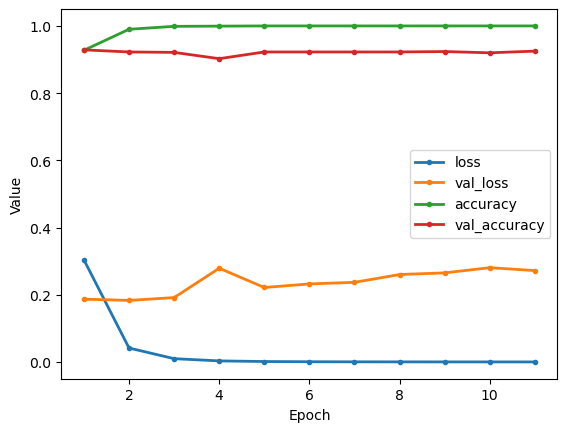

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

12/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

12/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [26]:
report.save()

Report saved as Output/Reports/MYB_related/report_08GVIF70.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [28]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [30]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [31]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [32]:
# END

In [33]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################